# Multichannel WDM waveform optimisation

For waveform optimisation we can distinguish three different approaches:
1. Optimisation on TX side (RX is RRC)
2. Optimisation on RX side (TX is RRC)
3. Optimisation on both sides

Let's start with the third one.

## Optimisation on both sides

In [105]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import os

from scipy.fft import fftshift, ifftshift, ifft, fftfreq
from scipy.optimize import minimize, NonlinearConstraint, OptimizeResult

# import hpcom
from datetime import datetime

from hpcom.signal import create_wdm_parameters, generate_wdm, generate_wdm_optimise, receiver, receiver_wdm,\
    nonlinear_shift, dbm_to_mw, get_default_wdm_parameters, rrcosfilter, update_wdm_parameters_from_json, get_points_wdm
from hpcom.modulation import get_modulation_type_from_order, get_scale_coef_constellation, \
    get_nearest_constellation_points_unscaled
from hpcom.metrics import get_ber_by_points, get_ber_by_points_ultimate, get_energy, get_average_power, get_evm_ultimate, get_evm
from hpcom.channel import create_channel_parameters, full_line_model, full_line_model_wdm, update_channel_parameters_from_json

from ssfm_gpu.propagation import propagate_manakov, propagate_manakov_backward, \
    propagate_schrodinger, dispersion_compensation_manakov


from wf_opt_additional import *

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-07-13 10:31:51.387991: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-13 10:31:51.390454: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-07-13 10:31:51.438811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-13 10:31:51.439131: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3070 Laptop GPU computeCapability: 8.6
coreClock: 1.56GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2023-07-13 10:31:51.439152: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-07-13 10:31:51.451924: I tensorflow/stream_executor/p

## Test that everything works

In [3]:
# create parameters
# wdm = create_wdm_parameters(n_channels=3, p_ave_dbm=3, n_symbols=2 ** 15, m_order=64, roll_off=0.1, upsampling=16,
#                             downsampling_rate=1, symb_freq=34e9, channel_spacing=75e9, n_polarisations=2)
#
#
# channel = create_channel_parameters(n_spans=12,
#                                     z_span=80,
#                                     alpha_db=0.2,
#                                     gamma=1.2,  # 1.2
#                                     noise_figure_db=-200,
#                                     dispersion_parameter=16.8,
#                                     dz=1)

# OR read from file

wdm_json = 'wdm_parameters.json'
channel_json = 'channel_parameters.json'
wdm = update_wdm_parameters_from_json(wdm_json)
channel = update_channel_parameters_from_json(channel_json)

In [4]:
result = full_line_model_wdm(channel, wdm, channels_type='all', verbose=3)

2023-07-13 10:36:40.659944: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2023-07-13 10:38:25.919587: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Average signal power (x / y): 0.0149928 / 0.0149946 (has to be close to 0.0150000)
propagation took 6528.964 ms
Signal energy before propagation (x / y): 0.030302876368659463 0.030306410367041108
Signal energy after propagation (x / y): 0.03030287636865779 0.030306410367039658
Signal energy difference (x / y): 1.672273430841642e-15 1.4502288259166107e-15
WDM channel 0
search x and y points took 62.46 ms
ber for x and y took 117.373 ms
BER (x / y): (0.16545867919921875, 43374) (0.16797256469726562, 44033)
Q^2-factor (x / y): 0.9722677600862852 0.962208003898567
WDM channel 1
search x and y points took 47.182 ms
ber for x and y took 116.09700000000001 ms
BER (x / y): (0.17707443237304688, 46419) (0.17620086669921875, 46190)
Q^2-factor (x / y): 0.9265718719694811 0.929940806552048
WDM channel 2
search x and y points took 43.151 ms
ber for x and y took 113.679 ms
BER (x / y): (0.16931915283203125, 44386) (0.16720199584960938, 43831)
Q^2-factor (x / y): 0.9568592420690704 0.9652811877535743

In [7]:
print(result['evm_x'])

[1.8026797748611965, 1.9049376360775572, 1.8391260264597735]


## Optimisation based on Newton method

Settings

In [14]:
data_dir = 'data/'
job_name = 'classic_type_1_test'
job_name_load = 'classic_type_1_test'
n_max_iter = 3
load_flag = False

In [40]:
filename = data_dir + job_name + '_states.pkl'  # The file where the states will be stored.
filename_load = data_dir + job_name_load + '_states.pkl'
filename_plot = data_dir + job_name + '_plot.png'

filename_wf_opt = data_dir + "wf_opt_" + job_name + ".npy"
filename_wf_opt_load = data_dir + "wf_opt_" + job_name_load + ".npy"

filename_fitnesses = data_dir + "fitnesses_" + job_name + ".npy"

# fitnesses = []  # list of fitnesses

In [51]:
# def callback(xk, state=None) -> bool:
#
#     print('Callback called back!')
#
#     f_data_save = True
#
#     if state is None:
#         # save x to the file
#         if f_data_save:
#             np.save(data_dir + "data_wf_opt" + job_name + ".npy", xk)
#         # print(xk)
#         return False
#
#     # only for method=‘trust-constr’
#     print("Number of iterations / function evaluation:", state['nit'], state['nfev'])
#
#     # save x to the file
#     save_freq = 1  # frequency of saving
#     if f_data_save and state['nit'] % save_freq == 0:
#             np.save(data_dir + "data_wf_opt_" + job_name + ".npy", xk)
#
#     if state['nfev'] >= 10:
#         return True
#     else:
#         return False

def callback(xk):

    print('Callback called back!')

    args_for_f = (channel, wdm, None, None, ft_filter_size, 'evm_x', is_odd, split)

    f_data_save = True
    f_add_fitness = True
    # save x to the file
    if f_data_save:
        if os.path.exists(filename_wf_opt):
            existing_xk = np.load(filename_wf_opt)
            new_xk = np.vstack((existing_xk, xk))
            np.save(filename_wf_opt, new_xk)
        else:
            np.save(filename_wf_opt, xk[np.newaxis, :])  # Save xk as a new row

    if f_add_fitness:
        current_fitness = f_minimise(xk, *args_for_f)
        if os.path.exists(filename_fitnesses):
            existing_fitnesses = np.load(filename_fitnesses)
            new_fitnesses = np.concatenate((existing_fitnesses, np.array([current_fitness])))
            np.save(filename_fitnesses, new_fitnesses)
        else:
            np.save(filename_fitnesses, np.array([current_fitness]))  # Save current_fitness as a new row
        plot_fitnesses(np.load(filename_fitnesses), filename_plot)


# def callback(intermediate_result: OptimizeResult):
#
#     # intermediate_result is scipy.optimize.OptimizeResult object
#
#     print('Callback called back!')
#
#     f_data_save = True
#
#     # only for method=‘trust-constr’
#     print("Number of iterations / function evaluation:", intermediate_result['nit'], intermediate_result['nfev'])
#
#     # save x to the file
#     save_freq = 1  # frequency of saving
#     if f_data_save and intermediate_result['nit'] % save_freq == 0:
#             np.save(filename_wf_opt, intermediate_result['x'])
#
#     plot_freq = 1
#     if intermediate_result['nit'] % plot_freq == 0:
#         plot_fitnesses(fitnesses, filename_plot)

In [97]:
def f_minimise(x, *args):

    # x - values for optimisation - cutted spectrum with 2n real values
    # and only left half of the spectrum
    x = np.array(x)

    start_time = datetime.now()

    channel = args[0]
    wdm = args[1]
    points_x = args[2]
    points_y = args[3]
    spectrum_size = args[4]
    return_type = args[5]
    is_odd = args[6]
    split = args[7]

    # decompose to complex numbers and restore full spectrum from half
    if split:
        cut_spectrum = restore_array(decompose(x), is_odd=is_odd)
    else:
        cut_spectrum = decompose(x)

    # for w-space
    spectrum = spectrum_add_zero_sides(cut_spectrum, spectrum_size)
    filter_values = ifft(ifftshift(spectrum))

    n_t = wdm['upsampling'] * wdm['n_symbols']
    filter_upsampled = upsample_zero_sides(filter_values, n_t)
    filter_upsampled = tf.cast(filter_upsampled, tf.complex128)
    filter_upsampled_conj = tf.cast(np.conjugate(filter_upsampled), tf.complex128)

    ft_filter_values = tf.signal.fftshift(tf.signal.fft(filter_upsampled))
    ft_filter_values_conj = tf.signal.fftshift(tf.signal.fft(filter_upsampled_conj))

    norm_coef = tf.reduce_mean(tf.math.pow(tf.math.abs(ft_filter_values), 2))
    print("Normalisation coefficient of ft_filter_values", norm_coef)

    ft_filter_values = ft_filter_values * tf.cast(tf.math.sqrt(wdm['upsampling'] / norm_coef), tf.complex128)

    # result = ch.full_line_model_optimise(channel, wdm, points_x, points_y, ft_filter_values, ft_filter_values_conj, return_type=return_type)

    ft_filter_tx = [[ft_filter_values for _ in range(wdm['n_channels'])] for _ in range(2)]
    ft_filter_rx = [[ft_filter_values_conj for _ in range(wdm['n_channels'])] for _ in range(2)]

    result = full_line_model_wdm(channel, wdm, verbose=2, optimise=return_type, channels_type='middle',
                                 ft_filter_values_tx=ft_filter_tx,
                                 ft_filter_values_rx=ft_filter_rx)

    end_time = datetime.now()
    time_diff = (end_time - start_time)
    execution_time = time_diff.total_seconds() * 1000
    print("Function evaluation took", execution_time, "ms")

    return result


## Example fitness

In [87]:
split = True
ft_filter_size = 2 ** 9 # size of optimized spectrum
bandwidth_frac = 1.1

init_filter_to_optimize = rrcosfilter(ft_filter_size, wdm['roll_off'], 1. / wdm['symb_freq'], wdm['sample_freq'])
ft_init_filter = tf.signal.fftshift(tf.signal.fft(init_filter_to_optimize))
freq = fftshift(fftfreq(ft_filter_size, d=1. / wdm['sample_freq']))
init_cut_spectrum = get_spec_limited(ft_init_filter.numpy(), freq, wdm['symb_freq'] * bandwidth_frac)
freq_cut = get_spec_limited(freq, freq, wdm['symb_freq'] * bandwidth_frac)

if len(init_cut_spectrum) % 2 == 0:
    is_odd = False
else:
    is_odd = True

if split:
    x = compose(split_array(init_cut_spectrum))
else:
    x = compose(init_cut_spectrum)

print('Number of variables to optimise:', len(x))

# decompose to complex numbers and restore full spectrum from half
if split:
    cut_spectrum = restore_array(decompose(x), is_odd=is_odd)
else:
    cut_spectrum = decompose(x)
# for w-space
spectrum = spectrum_add_zero_sides(cut_spectrum, ft_filter_size)
filter_values = ifft(ifftshift(spectrum))

n_t = wdm['upsampling'] * wdm['n_symbols']
filter_upsampled = upsample_zero_sides(filter_values, n_t)
filter_upsampled = tf.cast(filter_upsampled, tf.complex128)
filter_upsampled_conj = tf.cast(np.conjugate(filter_upsampled), tf.complex128)

freq_ups = fftshift(fftfreq(n_t, d=1. / wdm['sample_freq']))

ft_filter_values = tf.signal.fftshift(tf.signal.fft(filter_upsampled))
ft_filter_values_conj = tf.signal.fftshift(tf.signal.fft(filter_upsampled_conj))

norm_coef = tf.reduce_mean(tf.math.pow(tf.math.abs(ft_filter_values), 2))
print("Normalisation coefficient of ft_filter_values", norm_coef)
ft_filter_values = ft_filter_values * tf.cast(tf.math.sqrt(wdm['upsampling'] / norm_coef), tf.complex128)


Number of variables to optimise: 36
Normalisation coefficient of ft_filter_values tf.Tensor(15.998798848290708, shape=(), dtype=float64)


/home/esf0/anaconda3/envs/nn_env/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/esf0/anaconda3/envs/nn_env/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


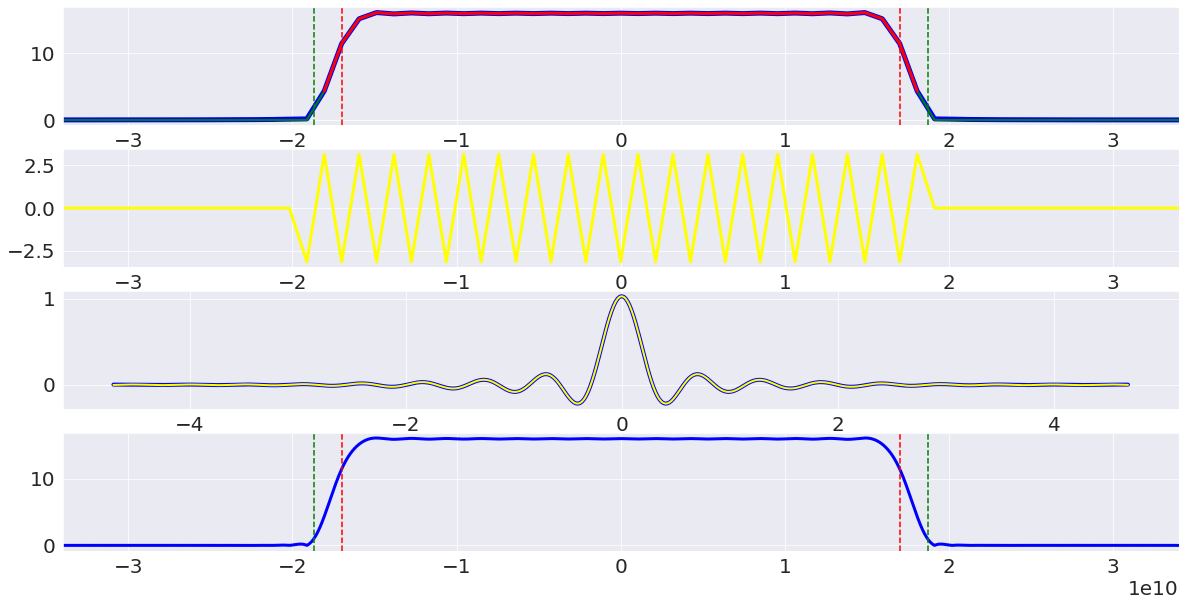

In [88]:
dt = 1 / wdm['sample_freq']
t_grid = (np.arange(ft_filter_size) - ft_filter_size / 2) * dt

f_coef = 1.0
fig, axs = plt.subplots(4, 1, figsize=(20, 10))
axs[0].plot(freq, np.absolute(ft_init_filter), linewidth=5, color='blue')
axs[0].plot(freq, np.absolute(spectrum), linewidth=2, color='green')

axs[0].plot(freq_cut, np.absolute(init_cut_spectrum), linewidth=3, color='red')

axs[0].axvline(x=wdm['symb_freq'] / 2, color='r', linestyle='--')
axs[0].axvline(x=-wdm['symb_freq'] / 2, color='r', linestyle='--')
axs[0].axvline(x=wdm['symb_freq'] * bandwidth_frac / 2, color='g', linestyle='--')
axs[0].axvline(x=-wdm['symb_freq'] * bandwidth_frac / 2, color='g', linestyle='--')
axs[0].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])
axs[0].grid(True)

# axs[1].plot(freq, np.absolute(spectrum), linewidth=3, color='purple')
axs[1].plot(freq[:-1], (np.angle(spectrum[:-1]) - np.angle(spectrum[1:])), linewidth=3, color='yellow')
axs[1].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])
axs[1].grid(True)

axs[2].plot(t_grid, ifft(ifftshift(spectrum)), linewidth=4, color='blue')
axs[2].plot(t_grid, ifft(ifftshift(ft_init_filter)), linewidth=2, color='yellow')
# axs[2].plot(freq, np.imag(ft_init_filter), linewidth=3, color='purple')
# axs[2].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])
axs[2].grid(True)

axs[3].plot(freq_ups, np.absolute(ft_filter_values), linewidth=3, color='blue')
axs[3].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])

axs[3].axvline(x=wdm['symb_freq'] / 2, color='r', linestyle='--')
axs[3].axvline(x=-wdm['symb_freq'] / 2, color='r', linestyle='--')
axs[3].axvline(x=wdm['symb_freq'] * bandwidth_frac / 2, color='g', linestyle='--')
axs[3].axvline(x=-wdm['symb_freq'] * bandwidth_frac / 2, color='g', linestyle='--')
axs[3].grid(True)

In [89]:
f_minimise(x, *(channel, wdm, None, None, ft_filter_size, 'evm_x', is_odd, split))

Normalisation coefficient of ft_filter_values tf.Tensor(15.998798848290708, shape=(), dtype=float64)
propagation took 6230.593 ms
search x and y points took 62.86899999999999 ms
ber for x and y took 122.779 ms
BER (x / y): (0.17669296264648438, 46319) (0.17779922485351562, 46609)
Q^2-factor (x / y): 0.9280417269024238 0.9237846480562649
Function evaluation took 7968.227 ms


3.7107323884913748

In [14]:
norm_c = tf.cast(tf.reduce_mean(tf.math.pow(tf.math.abs(ft_filter_values), 2)), tf.complex128)
print(tf.reduce_mean(tf.math.pow(tf.math.abs(ft_filter_values * tf.math.sqrt(wdm['upsampling'] / norm_c)), 2)))

tf.Tensor(15.999999999999996, shape=(), dtype=float64)


## Optimisation

In [53]:
# sample_freq = int(wdm['symb_freq'] * wdm['upsampling'])  # sampling frequency
# t_s = 1 / wdm['symb_freq']  # symbol spacing

ft_filter_size = 2 ** 4 # size of optimized spectrum
bandwidth_frac = 1.1

init_filter_to_optimize = rrcosfilter(ft_filter_size, wdm['roll_off'], 1. / wdm['symb_freq'], wdm['sample_freq'])
ft_init_filter = tf.signal.fftshift(tf.signal.fft(init_filter_to_optimize))
freq = fftshift(fftfreq(ft_filter_size, d=1. / wdm['sample_freq']))
init_cut_spectrum = get_spec_limited(ft_init_filter.numpy(), freq, wdm['symb_freq'] * bandwidth_frac)
freq_cut = get_spec_limited(freq, freq, wdm['symb_freq'] * bandwidth_frac)
print('Efficient number of points to optimise:', len(init_cut_spectrum))


if load_flag:
    x0 = np.load(filename_wf_opt_load, allow_pickle=True)
else:
    # set initial approximation
    if len(init_cut_spectrum) % 2 == 0:
        is_odd = False
    else:
        is_odd = True

    if split:
        x0 = compose(split_array(init_cut_spectrum))
    else:
        x0 = compose(init_cut_spectrum)

n_point_x = len(x0)

# print(type(x0), type(init_cut_spectrum), np.shape(x0), np.shape(init_cut_spectrum))
print('Check x0 mean ->', np.mean(x0), 'with len', n_point_x)  # I don't why but we have to do smt with x0 or it will be nan


Efficient number of points to optimise: 1
Check x0 mean -> 7.1054840087890625 with len 2


In [54]:
# main part
args = (channel, wdm, None, None, ft_filter_size, 'evm_x', is_odd, split)

# optimise
res = minimize(f_minimise,
               method='BFGS',
               x0=x0,
               args=args,
               callback=callback,
               options={'maxiter': n_max_iter, 'disp': True})

# write result to file
with open(filename, 'wb') as output:
    pickle.dump(res, output, pickle.HIGHEST_PROTOCOL)

Normalisation coefficient of ft_filter_values tf.Tensor(12.621975749789275, shape=(), dtype=float64)
propagation took 6479.676 ms
search x and y points took 62.17 ms
ber for x and y took 116.80699999999999 ms
BER (x / y): (0.14404296875, 37760) (0.14404678344726562, 37761)
Q^2-factor (x / y): 1.0623299167622509 1.0623131052595371
Function evaluation took 8136.3679999999995 ms
Normalisation coefficient of ft_filter_values tf.Tensor(12.621975776259266, shape=(), dtype=float64)
propagation took 6525.793000000001 ms
search x and y points took 62.191 ms
ber for x and y took 117.462 ms
BER (x / y): (0.14583969116210938, 38231) (0.14491653442382812, 37989)
Q^2-factor (x / y): 1.054444664808816 1.0584878900756731
Function evaluation took 8102.603999999999 ms
Normalisation coefficient of ft_filter_values tf.Tensor(12.621975749789275, shape=(), dtype=float64)
propagation took 6259.299999999999 ms
search x and y points took 62.114999999999995 ms
ber for x and y took 117.882 ms
BER (x / y): (0.143

In [25]:
print(fitnesses)

[]


## Optimisation using genetic algorithm

In [25]:
from deap import base
from deap import creator
from deap import tools

In [26]:
data_dir = 'data/'
job_name = 'test_genetic'
# n_max_iter = 1
load_flag = False

In [27]:
if load_flag:
    x0 = np.load(data_dir + "data_wf_opt" + job_name + ".npy", allow_pickle=True)
else:
    # set initial approximation
    if len(init_cut_spectrum) % 2 == 0:
        is_odd = False
    else:
        is_odd = True

    if split:
        x0 = compose(split_array(init_cut_spectrum))
    else:
        x0 = compose(init_cut_spectrum)

In [28]:
# create wrapper for minimisation function
def f_minimise_gen(x, args):
    return f_minimise(x, args),  # must return a tuple

# x0 our initial approximation

def add_noise_to_array(array, noise_scale=0.01):
    # Create random noise in the range [-noise_scale/2, noise_scale/2]
    noise = np.random.uniform(-noise_scale/2, noise_scale/2, array.shape)
    # Add the noise to the original array
    noisy_array = array + noise
    return noisy_array

def initial_value_function():
    return add_noise_to_array(x0, noise_scale=0.01)

In [37]:
test = initial_value_function()
print(np.shape(test), n_point_x)

(72,) 72


In [29]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [30]:
toolbox = base.Toolbox()
# Initialization functions
toolbox.register("attr_float", initial_value_function)  # or any other initialization function suitable for your problem
# toolbox.register("attr_float", np.random.random)  # or any other initialization function suitable for your problem
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=n_point_x)  # n is the length of the individual

def create_individual():
    return creator.Individual(add_noise_to_array(x0, noise_scale=0.01))
toolbox.register("individual", create_individual)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [32]:
args = (channel, wdm, None, None, ft_filter_size, 'evm_x', is_odd, split)

toolbox.register("evaluate", lambda x: f_minimise_gen(x, args))  # function to evaluate an individual's fitness
toolbox.register("mate", tools.cxTwoPoint)  # crossover (mating) operation
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)  # indpb represents the probability that each attribute (or 'gene') of an individual will be mutated
toolbox.register("select", tools.selTournament, tournsize=3)  # moderate selection pressure
# toolbox.register("select", tools.selTournament, tournsize=10)  # high selection pressure

In [43]:
# def save_state(data_dir, pop, best_individual, avg_fitnesses, generation):
#     state = {"pop": pop, "best_individual": best_individual,
#              "avg_fitnesses": avg_fitnesses, "generation": generation}
#     with open(data_dir + f'state_gen_{generation}.pkl', 'wb') as f:
#         pickle.dump(state, f)


def save_state(filename, pop, best_individual, avg_fitnesses, generation):
    # The file where the states will be stored.
    # filename = 'states.pkl'

    # Load the states if the file exists, otherwise start with an empty list.
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            states = pickle.load(f)
    else:
        states = []

    # Append the new state.
    state = {"pop": pop, "best_individual": best_individual,
             "avg_fitnesses": avg_fitnesses, "generation": generation}
    states.append(state)

    # Write all the states back into the file.
    with open(filename, 'wb') as f:
        pickle.dump(states, f)


def plot_and_save(avg_fitnesses, best_fitnesses, filename):
    plt.figure()
    plt.plot(avg_fitnesses, label='Average Fitness')
    plt.plot(best_fitnesses, label='Best Fitness')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.yscale('log')  # set log scale for y-axis
    plt.legend()
    plt.savefig(filename)
    plt.close()

In [44]:
def main():
    filename = data_dir + job_name + '_states.pkl'  # The file where the states will be stored.
    filename_plot = data_dir + job_name + '_plot.png'  # The file where the states will be stored.

    pop = toolbox.population(n=10)  # Initialize population. Adjust size as necessary.
    CXPB = 0.5  # Crossover probability with which two individuals will exchange part of their structure
    MUTPB = 0.05  # Mutation probability. Mutation is a background operator to maintain diversity in the population
    NGEN = 10  # Number of generations (iterations)
    ELITISM_SIZE = 3  # number of best individuals to keep from one generation to the next

    # Evaluate the entire population
    # fitnesses = list(map(toolbox.evaluate, pop))
    fitnesses = []
    for individual in pop:
        fitness = toolbox.evaluate(individual)
        fitnesses.append(fitness)

    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    # Keep track of the best individual and its fitness.
    best_individual = None
    best_fitness = None

    # Keep track of the average fitness at each generation.
    avg_fitnesses = []
    best_fitnesses = []

    SAVE_INTERVAL = 2  # Save every 1 generations.

    # Evolution loop
    for g in range(NGEN):
        print("-- Generation %i --" % g)
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop) - ELITISM_SIZE)
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if np.random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if np.random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Add the best back to population:
        offspring.extend(tools.selBest(pop, ELITISM_SIZE))

        # Replace population
        pop[:] = offspring

        # Calculate average fitness of the current generation.
        avg_fitness = np.mean([ind.fitness.values[0] for ind in pop])
        avg_fitnesses.append(avg_fitness)
        best_fitness = np.max([ind.fitness.values[0] for ind in pop])
        best_fitnesses.append(best_fitness)

        # Update the best individual found so far.
        for ind in pop:
            if best_fitness is None or ind.fitness.values[0] > best_fitness:
                best_individual = ind
                best_fitness = ind.fitness.values[0]

        # Save the state of the GA every SAVE_INTERVAL generations.
        if g % SAVE_INTERVAL == 0:
            save_state(filename, pop, best_individual, avg_fitnesses, g)
            plot_and_save(avg_fitnesses, best_fitnesses, filename_plot)

    return pop

In [45]:
pop = main()
best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

Normalisation coefficient of ft_filter_values tf.Tensor(15.998616394652021, shape=(), dtype=float64)
propagation took 6891.889 ms
search x and y points took 58.778999999999996 ms
ber for x and y took 127.106 ms
BER (x / y): (0.17458724975585938, 45767) (0.17547988891601562, 46001)
Q^2-factor (x / y): 0.936191692872601 0.9327292515395232
Function evaluation took 8767.389 ms
Normalisation coefficient of ft_filter_values tf.Tensor(15.99862690539386, shape=(), dtype=float64)
propagation took 6813.403 ms
search x and y points took 62.291 ms
ber for x and y took 123.485 ms
BER (x / y): (0.17486190795898438, 45839) (0.17393112182617188, 45595)
Q^2-factor (x / y): 0.9351251323356645 0.9387439088962135
Function evaluation took 8416.077 ms
Normalisation coefficient of ft_filter_values tf.Tensor(15.998486375292147, shape=(), dtype=float64)
propagation took 6277.217000000001 ms
search x and y points took 62.216 ms
ber for x and y took 123.222 ms
BER (x / y): (0.17291259765625, 45328) (0.1755752563

## Check found solution

In [51]:
args_check = (channel, wdm, None, None, ft_filter_size, 'not', is_odd, split)
result_check = f_minimise(best_ind, args_check)

Normalisation coefficient of ft_filter_values tf.Tensor(15.999235244837006, shape=(), dtype=float64)
propagation took 6201.1269999999995 ms
search x and y points took 61.556 ms
ber for x and y took 117.642 ms
BER (x / y): (0.17436981201171875, 45710) (0.1736602783203125, 45524)
Q^2-factor (x / y): 0.9370368091634398 0.9397992246160557
Function evaluation took 7774.028 ms


In [117]:
def draw_waveform(wdm, x, ft_filter_size, bandwidth_frac, split, init_filter_to_optimize):

    ft_init_filter = tf.signal.fftshift(tf.signal.fft(init_filter_to_optimize))
    x = np.array(x, dtype=complex)

    # decompose to complex numbers and restore full spectrum from half
    if split:
        cut_spectrum = restore_array(decompose(x), is_odd=is_odd)
    else:
        cut_spectrum = decompose(x)
    # for w-space
    spectrum = spectrum_add_zero_sides(cut_spectrum, ft_filter_size)
    filter_values = ifft(ifftshift(spectrum))

    n_t = wdm['upsampling'] * wdm['n_symbols']
    filter_upsampled = upsample_zero_sides(filter_values, n_t)
    filter_upsampled = tf.cast(filter_upsampled, tf.complex128)
    filter_upsampled_conj = tf.cast(np.conjugate(filter_upsampled), tf.complex128)

    freq_ups = fftshift(fftfreq(n_t, d=1. / wdm['sample_freq']))

    ft_filter_values = tf.signal.fftshift(tf.signal.fft(filter_upsampled))
    ft_filter_values_conj = tf.signal.fftshift(tf.signal.fft(filter_upsampled_conj))

    norm_coef = tf.reduce_mean(tf.math.pow(tf.math.abs(ft_filter_values), 2))
    print("Normalisation coefficient of ft_filter_values", norm_coef)
    ft_filter_values = ft_filter_values * tf.cast(tf.math.sqrt(wdm['upsampling'] / norm_coef), tf.complex128)


    dt = 1 / wdm['sample_freq']
    t_grid = (np.arange(ft_filter_size) - ft_filter_size / 2) * dt

    f_coef = 1.0
    fig, axs = plt.subplots(5, 1, figsize=(25, 10))
    # axs[0].plot(freq, np.absolute(ft_init_filter), linewidth=5, color='blue')
    axs[0].plot(freq, np.absolute(spectrum), linewidth=2, color='green')
    # axs[0].plot(freq_cut, np.absolute(init_cut_spectrum), linewidth=3, color='red')

    axs[0].axvline(x=wdm['symb_freq'] / 2, color='r', linestyle='--')
    axs[0].axvline(x=-wdm['symb_freq'] / 2, color='r', linestyle='--')
    axs[0].axvline(x=wdm['symb_freq'] * bandwidth_frac / 2, color='g', linestyle='--')
    axs[0].axvline(x=-wdm['symb_freq'] * bandwidth_frac / 2, color='g', linestyle='--')
    axs[0].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])
    axs[0].grid(True)

    # axs[1].plot(freq, np.absolute(spectrum), linewidth=3, color='purple')
    axs[1].plot(freq[:-1], (np.angle(spectrum[:-1]) - np.angle(spectrum[1:])), linewidth=3, color='yellow')
    axs[1].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])
    axs[1].grid(True)

    axs[2].plot(t_grid, ifft(ifftshift(spectrum)), linewidth=4, color='blue')
    # axs[2].plot(t_grid, ifft(ifftshift(ft_init_filter)), linewidth=2, color='yellow')
    # axs[2].plot(freq, np.imag(ft_init_filter), linewidth=3, color='purple')
    # axs[2].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])
    axs[2].grid(True)

    axs[3].plot(freq_ups, np.absolute(ft_filter_values), linewidth=3, color='blue')
    axs[3].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])

    axs[3].axvline(x=wdm['symb_freq'] / 2, color='r', linestyle='--')
    axs[3].axvline(x=-wdm['symb_freq'] / 2, color='r', linestyle='--')
    axs[3].axvline(x=wdm['symb_freq'] * bandwidth_frac / 2, color='g', linestyle='--')
    axs[3].axvline(x=-wdm['symb_freq'] * bandwidth_frac / 2, color='g', linestyle='--')
    axs[3].grid(True)

    axs[4].plot(freq, np.absolute(spectrum - ft_init_filter), linewidth=2, color='green')
    axs[4].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])
    axs[4].grid(True)

    plt.show()

draw_waveform(wdm, best_ind, ft_filter_size, bandwidth_frac, split, init_filter_to_optimize)

NameError: name 'best_ind' is not defined

## Example of genetic algorithm

In [173]:
import random
from deap import base, creator, tools


In [3]:
# We want to minimize our function, so weights is -1.0
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
# An individual is a list of float values (in this case)
creator.create("Individual", list, fitness=creator.FitnessMin)

In [13]:
toolbox = base.Toolbox()
# Attribute generator for float values between -10 and 10
toolbox.register("attr_float", random.uniform, -10, 10)
# Structure initializers
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=1)
# For example, for individuals of length 2:
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


In [49]:
import math
import numpy as np

In [44]:
def evaluate(individual):
    # Our simple quadratic function
    # return sum(x**2 for x in individual),
    print(np.shape(individual))

    return pow((math.tan(individual[0] - math.pi / 4) - individual[1]), 2),

In [45]:
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
# toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)  # indpb represents the probability that each attribute (or 'gene') of an individual will be mutated
# toolbox.register("select", tools.selTournament, tournsize=3)  # moderate selection pressure
toolbox.register("select", tools.selTournament, tournsize=10)  # high selection pressure

Roulette Wheel Selection (also known as Fitness Proportionate Selection):

The selection pressure can be adjusted indirectly through the fitness function.
If the differences in fitness between individuals are larger,
the selection pressure is higher because fitter individuals have
a much better chance to be selected.
One potential issue with this method is that it may result in premature convergence.

In [ ]:
# toolbox.register("select", tools.selRoulette)  # selection pressure depends on fitness scores

Rank Selection:

Instead of using fitness values directly,
rank selection sorts the population first and then every individual
gets its fitness value assigned according to the rank.
The selection pressure in rank selection can be higher than in roulette
wheel selection because even small differences in fitness can result in very different ranks.
This can prevent premature convergence.

In [ ]:
# toolbox.register("select", tools.selBest)  # high selection pressure

In [51]:
def main():
    pop = toolbox.population(n=50)
    CXPB = 0.5  # Crossover probability with which two individuals will exchange part of their structure
    MUTPB = 0.05  # Mutation probability. Mutation is a background operator to maintain diversity in the population
    NGEN = 10
    ELITISM_SIZE = 3  # number of best individuals to keep from one generation to the next

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    # Evolution loop
    for g in range(NGEN):
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop) - ELITISM_SIZE)
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Add the best back to population:
        offspring.extend(tools.selBest(pop, ELITISM_SIZE))

        # Replace population
        pop[:] = offspring

    return pop

In [52]:
pop = main()
best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
Best individual is [-5.698700532620229, -0.2416176890560795], (0.0014407001401911409,)


In [43]:
print(evaluate(best_ind))
print((math.tan(best_ind[0] - math.pi / 4), best_ind[1]))

(2.3097313157381573e-08,)
(-0.4780082142092923, -0.4781601922115077)


# Optimisation of Rx filter

Idea is the following:
instead of optimising Tx and Rx filters simultaneously, we can optimise Rx filter only.

In [92]:
def transceiver_line_model(channel, wdm, bits=None, points=None, verbose=0, dbp=False, ft_filter_values_tx=None):
    """
        Simulates a full optical transmission line, including generation of a wavelength division multiplexed (WDM)
        signal with multiple WDM channels, propagation through a specified channel, and detection at the receiver.

        Args:
            channel: object, channel through which the WDM signal is passed
            wdm: dict, contains information about the WDM signal
            bits: tuple, number of bits in the x (and y) component of the signal (optional)
            points: tuple, points of the x (and y) component of the signal (optional)
            channels_type: str: 'all' -- calculate metrics for all channels, 'middle' -- calculate only for middle (optional)
            verbose: int: level of system messages. 0 -- nothing, 1 -- +metrics, 2 -- +time, 3 -- +everything (optional)
            dbp: bool: flag to dbp algorithm. Only True if you calculate DBP for already received points (optional)
            optimise: 'not' -- no optimisation, 'ber_x' -- optimise BER for x, 'evm_x' -- optimise EVM for x (optional)
            ft_filter_values_tx:
            ft_filter_values_rx:

        Returns:
            dict: containing the points and BER and Q-value of the signal in the x and y component

            - 'points_x' -- an array of the points of the x component of the signal after processing
            - 'points_orig_x' -- an array of the original points of the x component of the signal
            - 'points_x_shifted' -- an array of the points of the x component of the signal after shifting
            - 'points_x_found' -- an array of the nearest constellation points of the x component of the signal
            - 'points_y' -- an array of the points of the y component of the signal after processing
            - 'points_orig_y' -- an array of the original points of the y component of the signal
            - 'points_y_shifted' -- an array of the points of the y component of the signal after shifting
            - 'points_y_found' -- an array of the nearest constellation points of the y component of the signal
            - 'ber_x' -- the bit error rate of the x component of the signal
            - 'ber_y' -- the bit error rate of the y component of the signal
            - 'q_x' -- the Q-value of the x component of the signal
            - 'q_y' -- the Q-value of the y component of the signal

        """

    dt = 1. / wdm['sample_freq']

    signal_x, signal_y, wdm_info = generate_wdm(wdm, bits=bits, points=points, ft_filter_values=ft_filter_values_tx)

    points_x_orig = wdm_info['points_x']
    points_y_orig = wdm_info['points_y']

    ft_filter_values_x = wdm_info['ft_filter_values_x']
    ft_filter_values_y = wdm_info['ft_filter_values_y']

    np_signal = len(signal_x)

    e_signal_x = get_energy(signal_x, dt * np_signal)
    e_signal_y = get_energy(signal_y, dt * np_signal)
    p_signal_x = get_average_power(signal_x, dt)
    p_signal_y = get_average_power(signal_y, dt)
    p_signal_correct = dbm_to_mw(wdm['p_ave_dbm']) / 1000 / wdm['n_polarisations'] * wdm['n_channels']
    print("Average signal power (x / y): "
          "%1.7f / %1.7f (has to be close to %1.7f)" % (p_signal_x, p_signal_y, p_signal_correct)) if verbose >= 3 else ...

    # TODO: reconsider dbp logic
    start_time = datetime.now()
    if not dbp:
        signal_x, signal_y = propagate_manakov(channel, signal_x, signal_y, wdm['sample_freq'])
    else:
        print('DBP')
        channel_back = channel.copy()
        channel_back['z_span'] = -channel['z_span']

        # [propagate_manakov_backward] is the proper function for backpropagation
        # which properly handle attenuation of the signal
        # if you still wand to use [propagate_manakov] then you have to set alpha = -alpha for channel parameters
        signal_x, signal_y = propagate_manakov_backward(channel_back, signal_x, signal_y, wdm['sample_freq'])
    print("propagation took", (datetime.now() - start_time).total_seconds() * 1000, "ms") if verbose >= 2 else ...

    e_signal_x_prop = get_energy(signal_x, dt * np_signal)
    e_signal_y_prop = get_energy(signal_y, dt * np_signal)

    if verbose >= 3:
        print("Signal energy before propagation (x / y):", e_signal_x, e_signal_y)
        print("Signal energy after propagation (x / y):", e_signal_x_prop, e_signal_y_prop)
        print("Signal energy difference (x / y):",
              np.absolute(e_signal_x - e_signal_x_prop),
              np.absolute(e_signal_y - e_signal_y_prop))

    if not dbp:
        signal_x, signal_y = dispersion_compensation_manakov(channel, signal_x, signal_y, 1. / wdm['sample_freq'])

    result = {
        'signal': [signal_x, signal_y],
        'points_orig': [points_x_orig, points_y_orig],
        'ft_filter_values': [ft_filter_values_x, ft_filter_values_y]
        }

    return result


def receiver_model(wdm, signal, points_orig, ft_filter_values_rx,
                   channels_type='all', verbose=0, optimise='not'):

    signal_x = signal[0]
    signal_y = signal[1]

    samples_x = receiver_wdm(signal_x, ft_filter_values_rx[0], wdm)
    samples_y = receiver_wdm(signal_y, ft_filter_values_rx[1], wdm)

    points_x_orig = points_orig[0]
    points_y_orig = points_orig[1]

    # TODO: make CDC after receiver
    # for k in range(wdm['n_channels']):
    #     samples_x[k], samples_y[k] = dispersion_compensation(channel, samples_x[k], samples_y[k], wdm['downsampling_rate'] / wdm['sample_freq'])

    # print(np.shape(samples_x))

    sample_step = int(wdm['upsampling'] / wdm['downsampling_rate'])

    # TODO: rewrite this part. Use one for and inside check if channel_type is 'all' or 'middle' and store only one
    if channels_type == 'all':

        points_x = []
        points_y = []

        points_x_shifted = []
        points_y_shifted = []

        for k in range(wdm['n_channels']):

            points_x.append(get_points_wdm(samples_x[k], wdm))
            points_y.append(get_points_wdm(samples_y[k], wdm))

            nl_shift_x = nonlinear_shift(points_x[k], points_x_orig[k])
            points_x_shifted.append(points_x[k] * nl_shift_x)

            nl_shift_y = nonlinear_shift(points_y[k], points_y_orig[k])
            points_y_shifted.append(points_y[k] * nl_shift_y)

        mod_type = get_modulation_type_from_order(wdm['m_order'])
        scale_constellation = get_scale_coef_constellation(mod_type) / np.sqrt(wdm['p_ave'] / wdm['n_polarisations'])

        points_x_found = []
        points_y_found = []

        ber_x = []
        ber_y = []
        q_x = []
        q_y = []
        evm_x = []
        evm_y = []

        for k in range(wdm['n_channels']):
            print('WDM channel', k) if verbose >= 1 else ...

            start_time = datetime.now()
            points_x_found.append(get_nearest_constellation_points_unscaled(points_x_shifted[k], mod_type))
            points_y_found.append(get_nearest_constellation_points_unscaled(points_y_shifted[k], mod_type))
            print("search x and y points took",
                  (datetime.now() - start_time).total_seconds() * 1000, "ms") if verbose >= 2 else ...

            start_time = datetime.now()
            ber_x.append(get_ber_by_points(points_x_orig[k] * scale_constellation, points_x_found[k], mod_type))
            ber_y.append(get_ber_by_points(points_y_orig[k] * scale_constellation, points_y_found[k], mod_type))
            print("ber for x and y took",
                  (datetime.now() - start_time).total_seconds() * 1000, "ms") if verbose >= 2 else ...

            q_x.append(np.sqrt(2) * sp.special.erfcinv(2 * ber_x[k][0]))
            q_y.append(np.sqrt(2) * sp.special.erfcinv(2 * ber_y[k][0]))

            evm_x.append(get_evm(points_x_orig[k] * scale_constellation, points_x_shifted[k] * scale_constellation))
            evm_y.append(get_evm(points_y_orig[k] * scale_constellation, points_y_shifted[k] * scale_constellation))

            print("BER (x / y):", ber_x[k], ber_y[k]) if verbose >= 1 else ...
            print(r'Q^2-factor (x / y):', q_x[k], q_y[k]) if verbose >= 1 else ...

    elif channels_type == 'middle':

        k = (wdm['n_channels'] - 1) // 2

        samples_x_temp = samples_x[k]
        samples_y_temp = samples_y[k]

        points_x = samples_x_temp[::sample_step].numpy()
        points_y = samples_y_temp[::sample_step].numpy()

        nl_shift_x = nonlinear_shift(points_x, points_x_orig[k])
        points_x_shifted = points_x * nl_shift_x

        nl_shift_y = nonlinear_shift(points_y, points_y_orig[k])
        points_y_shifted = points_y * nl_shift_y

        mod_type = get_modulation_type_from_order(wdm['m_order'])
        scale_constellation = get_scale_coef_constellation(mod_type) / np.sqrt(wdm['p_ave'] / wdm['n_polarisations'])

        start_time = datetime.now()
        points_x_found = get_nearest_constellation_points_unscaled(points_x_shifted, mod_type)
        points_y_found = get_nearest_constellation_points_unscaled(points_y_shifted, mod_type)
        print("search x and y points took",
              (datetime.now() - start_time).total_seconds() * 1000, "ms") if verbose >= 2 else ...

        start_time = datetime.now()
        ber_x = get_ber_by_points(points_x_orig[k] * scale_constellation, points_x_found, mod_type)
        ber_y = get_ber_by_points(points_y_orig[k] * scale_constellation, points_y_found, mod_type)
        print("ber for x and y took",
              (datetime.now() - start_time).total_seconds() * 1000, "ms") if verbose >= 2 else ...

        q_x = np.sqrt(2) * sp.special.erfcinv(2 * ber_x[0])
        q_y = np.sqrt(2) * sp.special.erfcinv(2 * ber_y[0])

        evm_x = get_evm(points_x_orig[k] * scale_constellation, points_x_shifted[k] * scale_constellation)
        evm_y = get_evm(points_y_orig[k] * scale_constellation, points_y_shifted[k] * scale_constellation)

        print("BER (x / y):", ber_x, ber_y) if verbose >= 1 else ...
        print(r'Q^2-factor (x / y):', q_x, q_y) if verbose >= 1 else ...

    else:
        print('Error[full_line_model_wdm]: no such type of channels_type variable')


    if optimise == 'not':

        result = {
            'points_x': points_x,
            'points_x_orig': points_x_orig,
            'points_x_shifted': points_x_shifted,
            'points_x_found': points_x_found,
            'points_y': points_y,
            'points_y_orig': points_y_orig,
            'points_y_shifted': points_y_shifted,
            'points_y_found': points_y_found,
            'ber_x': ber_x,
            'ber_y': ber_y,
            'q_x': q_x,
            'q_y': q_y,
            'evm_x': evm_x,
            'evm_y': evm_y
        }

    elif optimise == 'ber_x':
        return ber_x
    elif optimise == 'ber_y':
        return ber_y
    elif optimise == 'evm_x':
        return evm_x
    elif optimise == 'evm_y':
        return evm_y
    else:
        print('Error[full_line_model_wdm]: no such type of optimise variable')
        return None

    return result

In [93]:
result_tx = transceiver_line_model(channel, wdm, verbose=3)
result_rx = receiver_model(wdm,
                           result_tx['signal'],
                           result_tx['points_orig'],
                           result_tx['ft_filter_values'],
                           channels_type='all', verbose=3)

Average signal power (x / y): 0.0150377 / 0.0150316 (has to be close to 0.0150000)
propagation took 6297.355 ms
Signal energy before propagation (x / y): 0.03039352006554001 0.030381300765673372
Signal energy after propagation (x / y): 0.03039352006553796 0.03038130076567143
Signal energy difference (x / y): 2.050443148604586e-15 1.942890293094024e-15
WDM channel 0
search x and y points took 62.94 ms
ber for x and y took 122.563 ms
BER (x / y): (0.16896438598632812, 44293) (0.1696319580078125, 44468)
Q^2-factor (x / y): 0.958265745835785 0.9556206674219023
WDM channel 1
search x and y points took 49.902 ms
ber for x and y took 121.003 ms
BER (x / y): (0.17882537841796875, 46878) (0.17864227294921875, 46830)
Q^2-factor (x / y): 0.9198507532686853 0.9205516678234267
WDM channel 2
search x and y points took 47.449999999999996 ms
ber for x and y took 130.957 ms
BER (x / y): (0.17052459716796875, 44702) (0.1670989990234375, 43804)
Q^2-factor (x / y): 0.9520942313800309 0.9656926507955801


In [94]:
result_rx['evm_x']

[1.8423150560192714, 1.9315871935813598, 1.8656757674347066]

In [114]:
def callback_rx(xk):

    print('Callback called back!')

    args_for_f = (channel, wdm, None, None, ft_filter_size, 'evm_x', is_odd, split)

    f_data_save = True
    f_add_fitness = True
    # save x to the file
    if f_data_save:
        if os.path.exists(filename_wf_opt):
            existing_xk = np.load(filename_wf_opt)
            new_xk = np.vstack((existing_xk, xk))
            np.save(filename_wf_opt, new_xk)
        else:
            np.save(filename_wf_opt, xk[np.newaxis, :])  # Save xk as a new row

    if f_add_fitness:
        current_fitness = f_minimise_rx(xk, *args_for_f)
        if os.path.exists(filename_fitnesses):
            existing_fitnesses = np.load(filename_fitnesses)
            new_fitnesses = np.concatenate((existing_fitnesses, np.array([current_fitness])))
            np.save(filename_fitnesses, new_fitnesses)
        else:
            np.save(filename_fitnesses, np.array([current_fitness]))  # Save current_fitness as a new row
        plot_fitnesses(np.load(filename_fitnesses), filename_plot)


def f_minimise_rx(x, *args):

    # x - values for optimisation - cutted spectrum with 2n real values
    # and only left half of the spectrum
    x = np.array(x)

    start_time = datetime.now()

    channel = args[0]
    wdm = args[1]
    points_x = args[2]
    points_y = args[3]
    spectrum_size = args[4]
    return_type = args[5]
    is_odd = args[6]
    split = args[7]

    # decompose to complex numbers and restore full spectrum from half
    if split:
        cut_spectrum = restore_array(decompose(x), is_odd=is_odd)
    else:
        cut_spectrum = decompose(x)

    # for w-space
    spectrum = spectrum_add_zero_sides(cut_spectrum, spectrum_size)
    filter_values = ifft(ifftshift(spectrum))

    n_t = wdm['upsampling'] * wdm['n_symbols']
    filter_upsampled = upsample_zero_sides(filter_values, n_t)
    filter_upsampled = tf.cast(filter_upsampled, tf.complex128)
    filter_upsampled_conj = tf.cast(np.conjugate(filter_upsampled), tf.complex128)

    ft_filter_values = tf.signal.fftshift(tf.signal.fft(filter_upsampled))
    ft_filter_values_conj = tf.signal.fftshift(tf.signal.fft(filter_upsampled_conj))

    norm_coef = tf.reduce_mean(tf.math.pow(tf.math.abs(ft_filter_values), 2))
    print("Normalisation coefficient of ft_filter_values", norm_coef)

    ft_filter_values = ft_filter_values * tf.cast(tf.math.sqrt(wdm['upsampling'] / norm_coef), tf.complex128)

    # result = ch.full_line_model_optimise(channel, wdm, points_x, points_y, ft_filter_values, ft_filter_values_conj, return_type=return_type)

    ft_filter_tx = [[ft_filter_values for _ in range(wdm['n_channels'])] for _ in range(2)]
    ft_filter_rx = [[ft_filter_values_conj for _ in range(wdm['n_channels'])] for _ in range(2)]

    # result = full_line_model_wdm(channel, wdm, verbose=2, optimise=return_type, channels_type='middle',
    #                              ft_filter_values_tx=ft_filter_tx,
    #                              ft_filter_values_rx=ft_filter_rx)

    result = receiver_model(wdm,
                            result_tx['signal'],
                            result_tx['points_orig'],
                            ft_filter_rx,
                            optimise=return_type,
                            channels_type='middle', verbose=2)

    end_time = datetime.now()
    time_diff = (end_time - start_time)
    execution_time = time_diff.total_seconds() * 1000
    print("Function evaluation took", execution_time, "ms")

    return result


In [102]:
data_dir = 'data/'
job_name = 'rx_type_1_test'
job_name_load = 'rx_type_1_test'
n_max_iter = 3
load_flag = False
filename = data_dir + job_name + '_states.pkl'  # The file where the states will be stored.
filename_load = data_dir + job_name_load + '_states.pkl'
filename_plot = data_dir + job_name + '_plot.png'

filename_wf_opt = data_dir + "wf_opt_" + job_name + ".npy"
filename_wf_opt_load = data_dir + "wf_opt_" + job_name_load + ".npy"

filename_fitnesses = data_dir + "fitnesses_" + job_name + ".npy"


In [103]:
ft_filter_size = 2 ** 10 # size of optimized spectrum
bandwidth_frac = 1.1

init_filter_to_optimize = rrcosfilter(ft_filter_size, wdm['roll_off'], 1. / wdm['symb_freq'], wdm['sample_freq'])
ft_init_filter = tf.signal.fftshift(tf.signal.fft(init_filter_to_optimize))
freq = fftshift(fftfreq(ft_filter_size, d=1. / wdm['sample_freq']))
init_cut_spectrum = get_spec_limited(ft_init_filter.numpy(), freq, wdm['symb_freq'] * bandwidth_frac)
freq_cut = get_spec_limited(freq, freq, wdm['symb_freq'] * bandwidth_frac)
print('Efficient number of points to optimise:', len(init_cut_spectrum))


if load_flag:
    x0 = np.load(filename_wf_opt_load, allow_pickle=True)
else:
    # set initial approximation
    if len(init_cut_spectrum) % 2 == 0:
        is_odd = False
    else:
        is_odd = True

    if split:
        x0 = compose(split_array(init_cut_spectrum))
    else:
        x0 = compose(init_cut_spectrum)

n_point_x = len(x0)

# print(type(x0), type(init_cut_spectrum), np.shape(x0), np.shape(init_cut_spectrum))
print('Check x0 mean ->', np.mean(x0), 'with len', n_point_x)  # I don't why but we have to do smt with x0 or it will be nan


Efficient number of points to optimise: 71
Check x0 mean -> 0.12126809449615353 with len 72


In [104]:
# main part
args = (channel, wdm, None, None, ft_filter_size, 'evm_x', is_odd, split)

# optimise
res = minimize(f_minimise_rx,
               method='BFGS',
               x0=x0,
               args=args,
               callback=callback_rx,
               options={'maxiter': n_max_iter, 'disp': True})

# write result to file
with open(filename, 'wb') as output:
    pickle.dump(res, output, pickle.HIGHEST_PROTOCOL)

Normalisation coefficient of ft_filter_values tf.Tensor(15.99986025123409, shape=(), dtype=float64)
search x and y points took 62.532000000000004 ms
ber for x and y took 120.542 ms
BER (x / y): (0.17884063720703125, 46882) (0.17858505249023438, 46815)
Q^2-factor (x / y): 0.9197923641205974 0.920770796384545
Function evaluation took 540.0350000000001 ms
Normalisation coefficient of ft_filter_values tf.Tensor(15.999860251183673, shape=(), dtype=float64)
search x and y points took 64.718 ms
ber for x and y took 193.185 ms
BER (x / y): (0.17884063720703125, 46882) (0.17858505249023438, 46815)
Q^2-factor (x / y): 0.9197923641205974 0.920770796384545
Function evaluation took 604.373 ms
Normalisation coefficient of ft_filter_values tf.Tensor(15.999860251505702, shape=(), dtype=float64)
search x and y points took 62.61600000000001 ms
ber for x and y took 117.588 ms
BER (x / y): (0.17884063720703125, 46882) (0.17858505249023438, 46815)
Q^2-factor (x / y): 0.9197923641205974 0.920770796384545
Fu

In [111]:
solutions = np.load(data_dir + "wf_opt_" + 'rx_type_1_run_1' + ".npy", allow_pickle=True)
print(solutions[-1])

[-1.62110179e+00  4.38654974e+00 -8.32741972e+00  1.18559511e+01
 -1.54713970e+01  1.62346789e+01 -1.67566381e+01  1.51530380e+01
 -1.58910128e+01  1.34732790e+01 -1.57619058e+01  1.79019757e+01
 -1.57329080e+01  1.73736286e+01 -1.76450485e+01  1.61359389e+01
 -1.40592654e+01  1.28751469e+01 -1.68331403e+01  1.57220874e+01
 -1.70526866e+01  1.60222014e+01 -1.57019150e+01  1.69669548e+01
 -1.43295803e+01  1.50559000e+01 -1.59778408e+01  1.81679090e+01
 -1.50925139e+01  1.67420990e+01 -1.58094291e+01  1.65439318e+01
 -1.48942145e+01  1.53833354e+01 -1.63002285e+01  1.57811144e+01
 -5.05880601e-01  6.39419103e-01 -8.39088916e-01  1.09517540e+00
  5.74521951e-01 -1.36692532e+00 -1.33069118e+00  1.08353775e+00
  1.35128118e+00 -4.06492645e-01 -1.96649078e-01  6.08932101e-01
  8.69387686e-02  9.49744545e-03 -4.06535695e-01  2.79603175e+00
 -8.51521462e-01  1.52048936e+00  2.73350260e-01 -1.68587337e-01
  2.14698500e-01 -3.44053614e-01  1.79813062e+00 -2.66358231e+00
  3.74293869e-01 -3.12944

In [115]:
for x_test in solutions:
    print('evm_x = ', f_minimise_rx(x_test, *args))

Normalisation coefficient of ft_filter_values tf.Tensor(16.430997284822112, shape=(), dtype=float64)
search x and y points took 63.027 ms
ber for x and y took 119.373 ms
BER (x / y): (0.1893310546875, 49632) (0.18885421752929688, 49507)
Q^2-factor (x / y): 0.8803640790127885 0.8821264409734623
Function evaluation took 468.678 ms
evm_x =  5.032771561389226
Normalisation coefficient of ft_filter_values tf.Tensor(16.01468975517305, shape=(), dtype=float64)
search x and y points took 63.85 ms
ber for x and y took 124.723 ms
BER (x / y): (0.17888259887695312, 46893) (0.17882537841796875, 46878)
Q^2-factor (x / y): 0.9196318101300582 0.9198507532686853
Function evaluation took 447.728 ms
evm_x =  4.723910734414502
Normalisation coefficient of ft_filter_values tf.Tensor(16.145542004022907, shape=(), dtype=float64)
search x and y points took 64.207 ms
ber for x and y took 165.947 ms
BER (x / y): (0.18169021606445312, 47629) (0.18111038208007812, 47477)
Q^2-factor (x / y): 0.9089425875008623 0.

Normalisation coefficient of ft_filter_values tf.Tensor(16.172156809019807, shape=(), dtype=float64)


/home/esf0/anaconda3/envs/nn_env/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


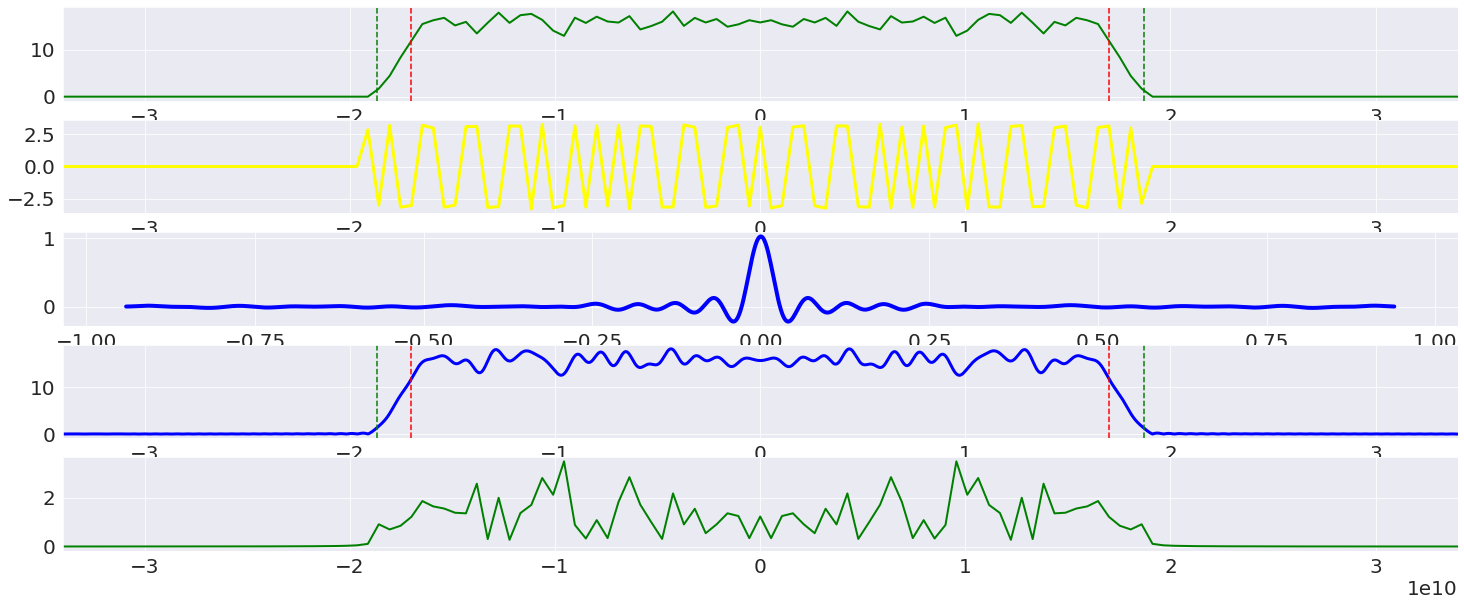

In [118]:
draw_waveform(wdm, solutions[-1], ft_filter_size, bandwidth_frac, split, init_filter_to_optimize)